In [ ]:
#### library("here")
library(devtools)
library(Seurat)

load_all('/home/jpm73279/Socrates')

# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/"

zm_leaf_rep_1 <- paste0(analysis_path, "Zm_rep1.merged.unique.mpq10.tn5.sorted.bed")

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "zm.Leaf_rep1"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.gff3")
chr <- paste0(reference_genome_path,"Zm-B73-REFERENCE-NAM-5.0.chrom.size")
pre <- "zm.Leaf_rep1.QC_v2"

In [2]:
#Load Object
zm_leaf_rep_1 <- loadBEDandGenomeData(zm_leaf_rep_1, ann, chr)
#zea_m.rep.peaks  <- paste0(pre, "macs2_temp", sep=".")

zm_leaf_rep_1.no_organelle <- countRemoveOrganelle(zm_leaf_rep_1, 
                                             org_scaffolds = c("Pt", "Mt"), 
                                             remove_reads = TRUE)

Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm_rep1.merged.unique.mpq10.tn5.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM-5.0.chrom.size ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data

Identified 825961 organeller reads ...



In [3]:
# call ACRs
zm_temp_dir <- paste0(analysis_path, "zm_peaks.rep1.do_over.tmp")
zm_leaf_rep_1.no_organelle <- callACRs(zm_leaf_rep_1.no_organelle, 
                genomesize=1.6e9,
                shift= -50,
                extsize=100,
                fdr=0.05,
                tempdir=zm_temp_dir,
                verbose=T)

zm_leaf_rep_1.meta <- buildMetaData(zm_leaf_rep_1.no_organelle,
                                     tss.window=2000,
                                     verbose=TRUE,
                                     organelle_scaffolds= c("Pt", "Mt"))

 - running MACS2 on bulk BED file ...

 - counting Tn5 sites per barcode ...

 - removing organelle scaffolds from annotation ...

 - counting Tn5 sites at TSSs per barcode ...

 - counting Tn5 sites within ACRs per barcode ...

 - finalizing meta data creation ...

   ~ returning metadata ...



Making Dotplot

... Filtering Cells based of Oragnelle Reads



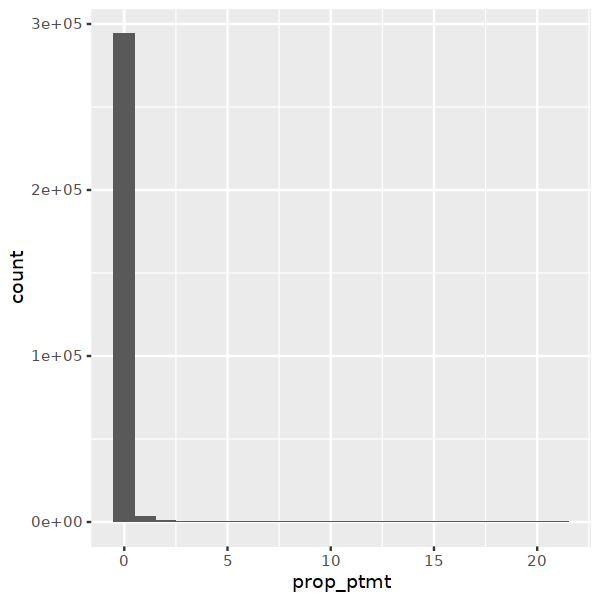

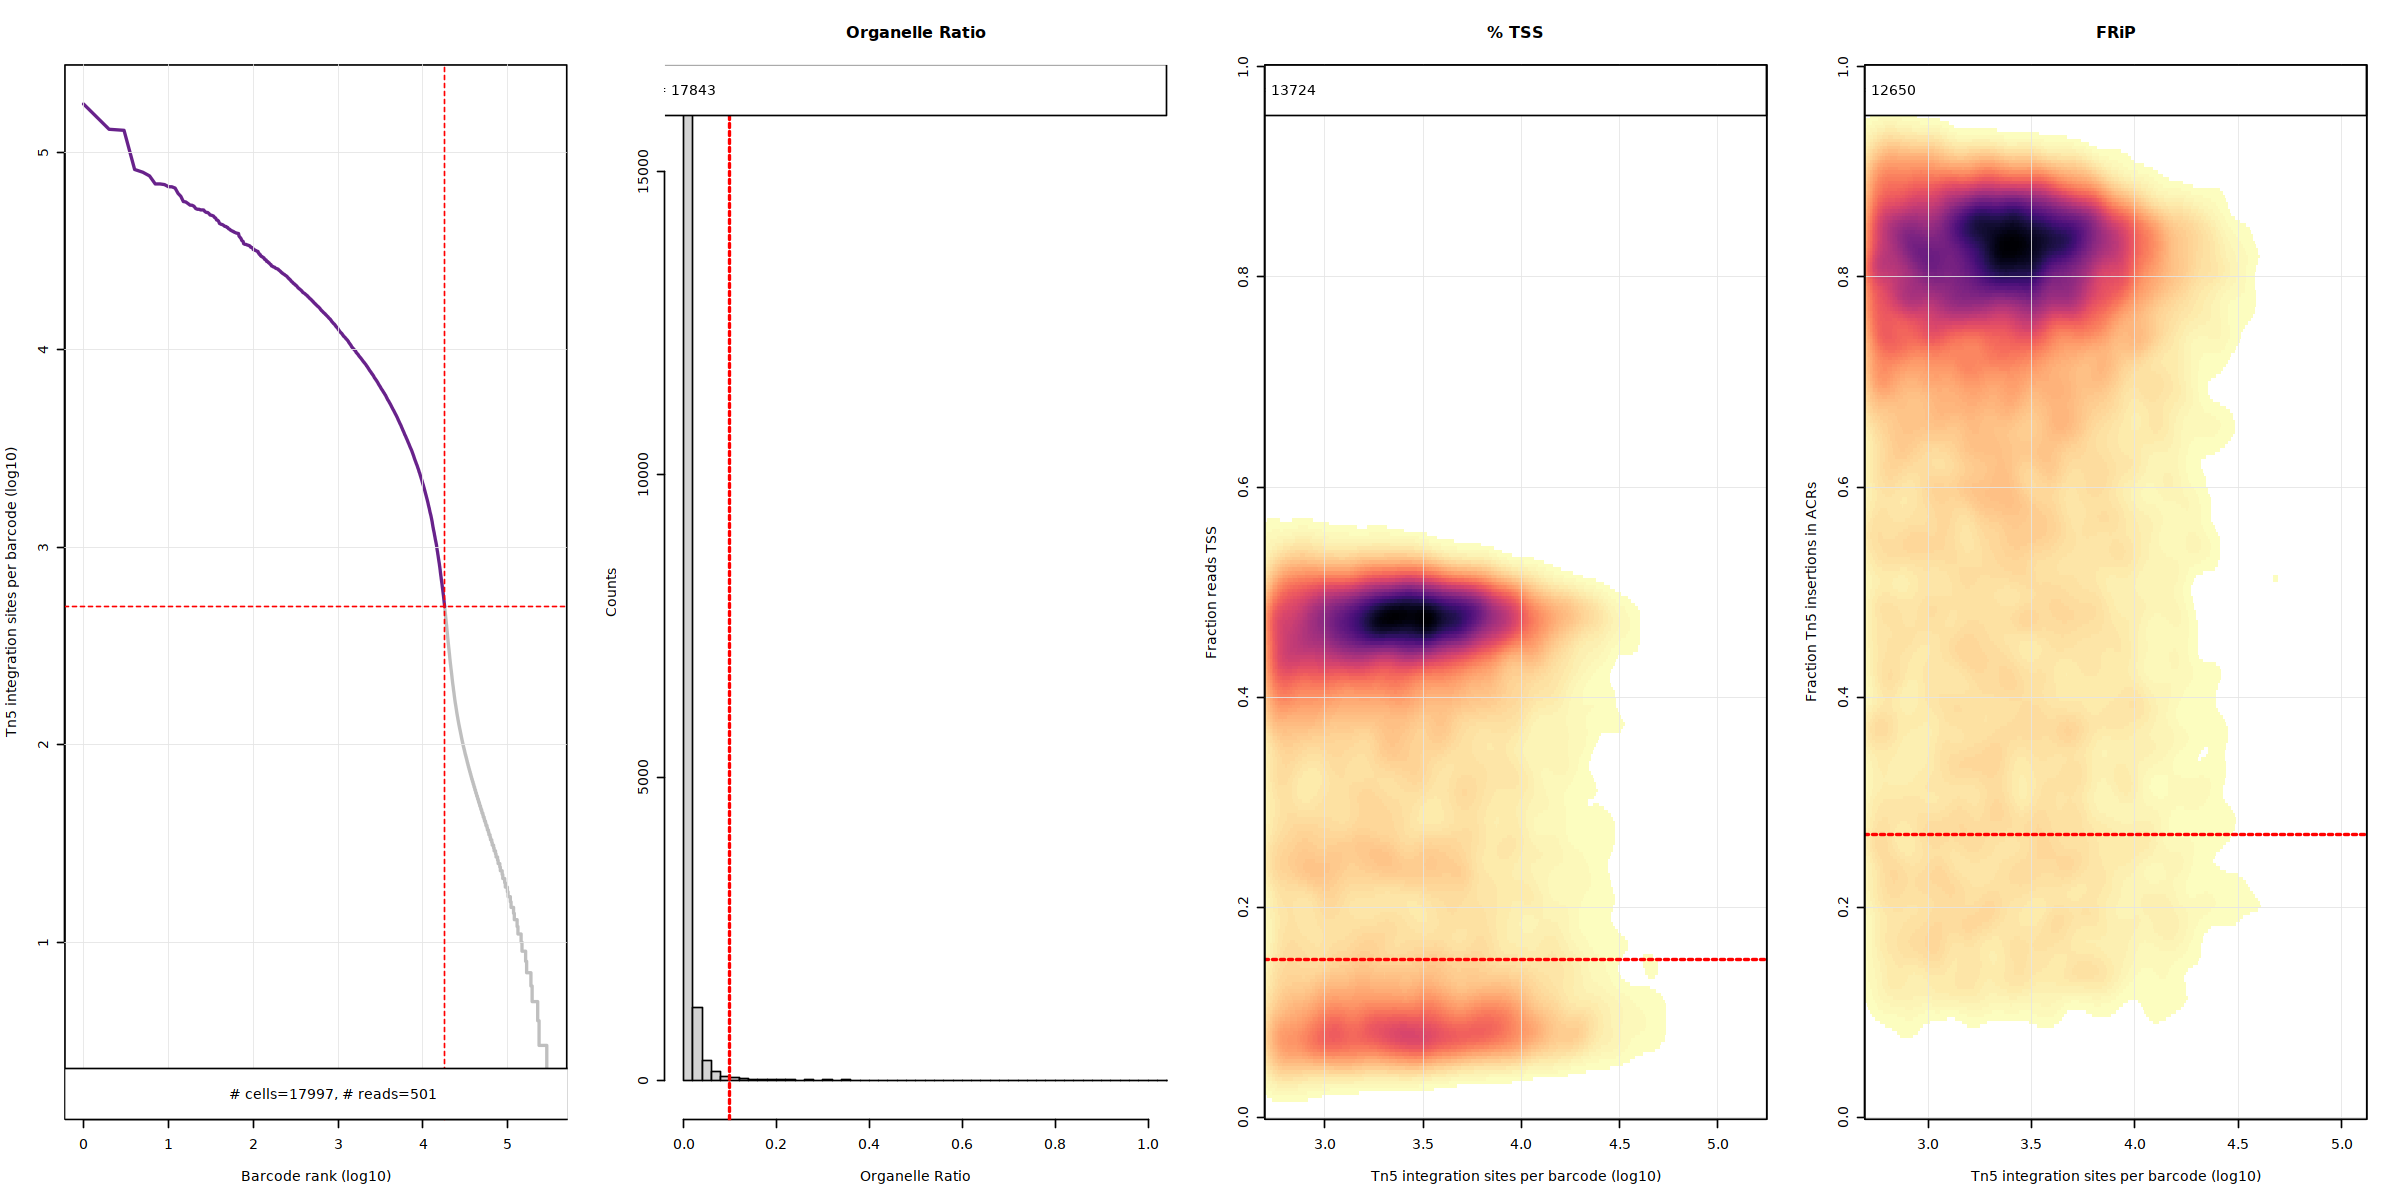

In [5]:
options(repr.plot.width=5, repr.plot.height=5)
library("dplyr")
zm_leaf_rep_1.meta$meta  %>% 
    dplyr::mutate(prop_ptmt = ptmt/total)  %>% 
    ggplot(., aes(prop_ptmt)) + geom_histogram(binwidth = 1)

library(repr)

options(repr.plot.width=20, repr.plot.height=10)
zm_leaf_rep_1.meta <- findCells(zm_leaf_rep_1.meta,
                                        doplot=T,
                                        set.tn5.cutoff=500,
                                        max.cells=20000,
                                        min.tn5=500,
                                        filt.tss=TRUE,
                                        filt.frip=TRUE,
                                        #tss.z.thresh=3,
                                        tss.min.freq=.15,
                                        frip.min.freq=0.15,
                                        filt.org = TRUE,
                                        org.filter.thresh=0.1,
                                        prefix=NULL)

In [7]:
# generate sparse matrix
zm_leaf_rep_1.meta.filtererd <- generateMatrix(zm_leaf_rep_1.meta,
                            filtered=FALSE,
                            windows=250,
                            peaks=FALSE,
                            organelle_scaffolds= c("Pt", "Mt"),
                            blacklist = "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/black_list_sc_ATAC/Zm.final_blaclist.final.bed",
                            verbose=T)

In [8]:
#rm(zea_m.Crown_root_1.obj.filtered, zea_m.Crown_root_1.obj.meta, zea_m.Crown_root_1.obj.no_organelle)

zm_leaf_rep_1.meta.filtererd <- isCell(zm_leaf_rep_1.meta.filtererd,
      num.ref = 5000, verbose = TRUE)

 - converting triplet format to sparseMatrix

 - setting filters

 - parsing initial boundaries

 - normalizing distributions and creating references

 - performing feature selection (this step is a bottle-neck and may take a while to complete)

 - estimating correlations



In [9]:
save_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output"

passing_cells <- zm_leaf_rep_1.meta.filtererd$meta  %>% 
    dplyr::filter(is_cell == 1)



zm_leaf_rep_1.meta.filtererd$meta.v3 <- passing_cells
    

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



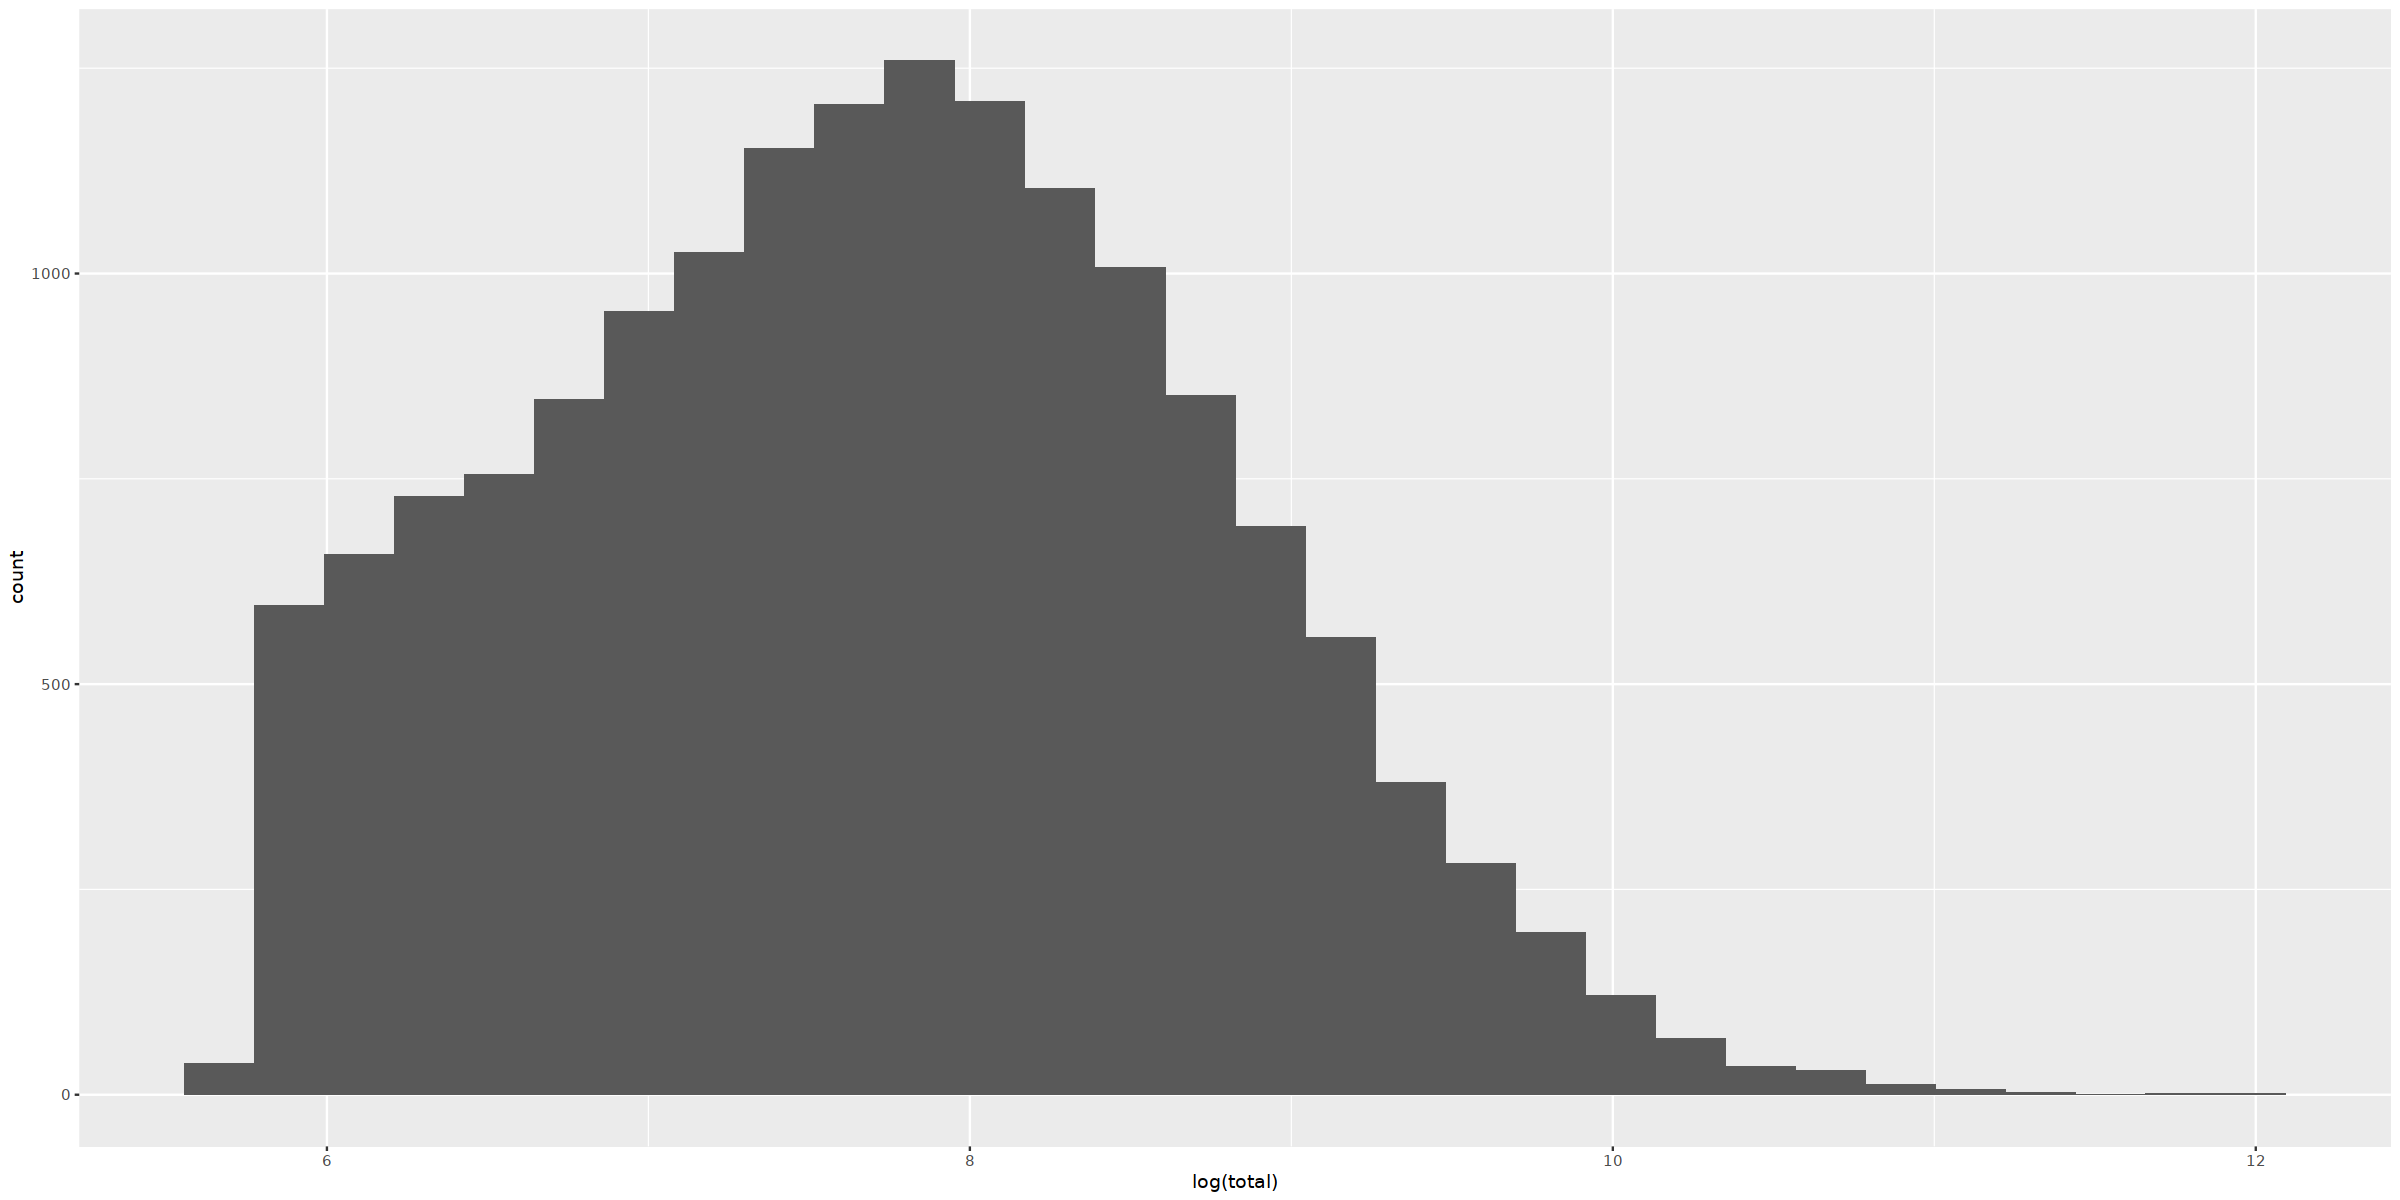

In [11]:
ggplot(passing_cells, aes(log(total))) + geom_histogram()

In [12]:
save_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output"

In [13]:
#pre <- "Sb.Leaf_rep1.QC_v2"
# convert to Socrates format for downstream analysis.-
zm_leaf_rep_1.meta.filtererd.sparse <- convertSparseData(zm_leaf_rep_1.meta.filtererd,
                             verbose=T)

#pre <- "Zea_mays_tis_crown_root_rep_1"
sb.obj.leaf_rep_1.save  <- paste0(save_path,"/",pre, "_QC_obj.rds")
sb.soc.leaf_rep_1.save  <- paste0(save_path,"/",pre, "_QC_soc_obj.rds")


# save QC object
saveRDS(zm_leaf_rep_1.meta.filtererd, file=sb.obj.leaf_rep_1.save)
saveRDS(zm_leaf_rep_1.meta.filtererd.sparse, file=sb.soc.leaf_rep_1.save)

 - converting triplet format to sparseMatrix



# Take QC Metrics for Excel

In [1]:
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/"


sb_replicate_1 <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb.Leaf_rep1_QC_soc_obj.rds")
sb_replicate_2 <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb.Leaf_rep2_QC_soc_obj.rds")

In [270]:
mean(sb_leaf_rep_1.filtered.sparse$meta$total)

[1] 3552.25

In [271]:
mean(sb_leaf_rep_1.filtered.sparse$meta$tss)

[1] 1940.266

In [272]:
mean(sb_leaf_rep_1.filtered.sparse$meta$acrs)

[1] 2383.729

In [274]:
mean(sb_leaf_rep_1.filtered.sparse$meta$nSites)

dim(sb_leaf_rep_1.filtered.sparse$meta)

[1] 19305    17